# DQN vs. DSQN for the CartPole Environment

## Miscellaneous

In [1]:
basis_dir = './results/'

# Setup

In [2]:
#@title Imports{ form-width: "20%", display-mode: "form" }
import os
import gym
import torch
import random

import numpy as np
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import importlib
import json

from datetime import date, datetime

from agent import Agent, ReplayBuffer
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import MinMaxScaler
from textwrap import wrap


#%matplotlib inline

In [55]:
experiment_type = ["default","twoneuron", "ttfs","poisson" , "fre"]
type_nr = 2

from model import QNetwork, DSNN
print("Imported {} model".format(experiment_type[type_nr]))

Imported ttfs model


In [4]:
# Environment specific parameters
env_name = 'CartPole-v0'
n_runs = 5
n_evaluations = 100
max_steps = 200
num_episodes = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Create Results Directory

dirs = os.listdir(basis_dir)
print(dirs)
if not any('result' in d for d in dirs):
    result_id = 1
else:
    results = [d for d in dirs if 'result' in d]
    result_id = len(results) + 1

# Get today's date and add it to the results directory
d = date.today()
result_dir = basis_dir  +'result_'+ str(result_id) + '_' + experiment_type[type_nr] + '_{}'.format(
    str(d.year) + str(d.month) + str(d.day))
os.mkdir(result_dir)
print('Created Directory {} to store the results in'.format(result_dir))


['result_12_poisson_2022324', 'result_8_poisson_2022322_pop', 'result_11_poisson_2022322', 'result_21_fre_2022411', 'result_25_poisson_2022426', 'result_14_poisson_2022328', 'result_9_poisson_2022124', 'result_10_poisson_2022322', 'result_1_poisson_20211215', 'result_13_fre_2022324', 'result_11_poisson_2022125', 'decent_ttfs_2', 'result_31_ttfs_2022518', 'result_21_poisson_2022412', 'result_10_poisson_2022124', 'result_15_poisson_2022329', 'result_24_poisson_2022412', 'decent_ttfs_5', 'result_29_poisson_2022514', 'result_20_poisson_2022411', 'result_18_fre_2022411', 'result_30_ttfs_2022516', 'result_7_poisson_202231', 'result_30_ttfs_2022515', 'result_23_poisson_2022412', 'result_9_poisson_2022322', 'result_4_poisson_202213', 'result_27_poisson_2022427', 'result_28_poisson_2022514', 'result_6_ttfs_2022119', 'result_16_poisson_2022329', 'result_17_fre_202247', 'result_22_poisson_2022412']
Created Directory ./results/result_32_ttfs_2022622 to store the results in


In [6]:
#@title Change Result Directory { form-width: "20%", display-mode: "form" }
#result_dir = 'result_12_20211028'

In [53]:
#@title Hyperparameters { form-width: "20%", display-mode: "form" }
batch_size = 1
discount_factor = 0.999
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.999
update_every = 4
target_update_frequency = 100
learning_rate = 0.003
replay_memory_size = 4*10**4
tau = 1e-3

In [54]:
#@title SNN Hyperparameters { form-width: "20%", display-mode: "form" }
time_step = 1e-3 # 1ms
simulation_time = 10
weight_scale = 1
threshold = 0.1
architecture = [4, 64, 64, 2]

# Tau
tau_mem = 10e-3
tau_syn = 5e-3
alpha = 0.1
beta = 0.8

#Calculated values, as can be found in XXXXXX
#alpha   = float(np.exp(-time_step/tau_syn))
#beta    = float(np.exp(-time_step/tau_mem))

population_coding=False
two_neuron=False
population_size = 3

In [9]:
seeds = [random.getrandbits(32) for _ in range(n_runs)]
np.save(result_dir + '/' + 'seeds', seeds)
#seeds = np.load(basis_dir + 'seeds.npy').tolist()

In [10]:
#@title Useful Functions { form-width: "20%", display-mode: "form" }
def loadScores(score_dir, score_name, amount):
    score_list = []
    for i in range(amount):
      score_list.append(np.load(score_dir + '/' + score_name + '_{}'.format(i) + '.npy'))
    return score_list

def create_params_dict():
    params = {}
    params.update( {'alpha' : alpha} )
    params.update( {'beta' : beta} )
    params.update( {'threshold' : threshold} )
    params.update( {'batch_size' : batch_size} )
    params.update( {'discount_factor' : discount_factor} )
    params.update( {'eps_start' : eps_start} )
    params.update( {'eps_end' : eps_end} )
    params.update( {'eps_decay' : eps_decay} )
    params.update( {'update_every' : update_every} )
    params.update( {'target_update_frequency' : target_update_frequency} )
    params.update( {'learning_rate' : learning_rate} )
    params.update( {'replay_memory_size' : replay_memory_size} )

    params.update( {'tau' : tau} )
    params.update( {'time_step' : time_step} )
    params.update( {'simulation_time' : simulation_time} )

    params.update( {'weight_scale' : weight_scale} )
    params.update( {'architecture' : architecture} )
    params.update( {'seeds' : seeds} )

    params.update( {'population_coding' : population_coding} )
    params.update( {'population_size' : population_size} )
    params.update( {'two_neuron' : two_neuron} )
    return params

def saveHyperparametersToFile():
    params = create_params_dict()

    # Serialize data into file:
    json.dump( params, open( result_dir +"/hyperparameters.json", 'w' ) )

def getDateTime():
  return datetime.now().strftime("%d/%m/%Y %H:%M:%S")  

# Plot scores of individual runs
def plot_score(smoothed_score,i, params = None):
    plt.clf()
    if params:
        param_title = str(params)
        plt.title('\n'.join(wrap(param_title,60)), fontsize=8)
    plt.plot(smoothed_score)
    plt.ylim(0, 250)
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(result_dir + '/training_dsqn_{}.png'.format(i), dpi=1000)
    #plt.show()

def init_scaler(two_neuron = False):
    scaler = MinMaxScaler()

    if two_neuron:
        scaler = MinMaxScaler(feature_range=(-1,1))

    if env_name == 'MountainCar-v0':
        limits = np.asarray([[-1.2, -0.07],
                          [0.6, 0.07]])
    else:
        #[position of cart, velocity of cart, angle of pole, rotation rate of pole]
        limits = np.asarray([[-4.8, -3, -0.21 , -3],
                          [4.8, 3 , 0.21, 3]])

    # fit data
    scaler.fit(limits)
    return scaler

# DSQN

## DSQN Setup

In [ ]:
# Enables the python console on exeption
%pdb off

In [ ]:
type_nr = 3

In [10]:
#@title Reload changed model file { form-width: "20%", display-mode: "form" }
model_string = "default"
if experiment_type[type_nr] == "twoneuron":
    model_string = "twoneuron"
    import model_twoneurons
    importlib.reload(model_twoneurons)
    from model_twoneurons import QNetwork, DSNN
elif experiment_type[type_nr] == "poisson":
    model_string = "poisson"
    import model_poisson
    importlib.reload(model_poisson)
    from model_poisson import QNetwork, DSNN
elif experiment_type[type_nr] == "ttfs":
    model_string = "ttfs"
    import model_ttfs
    importlib.reload(model_ttfs)
    from model_ttfs import QNetwork, DSNN
elif experiment_type[type_nr] == "fre":
    model_string = "fre"
    import model_fre
    importlib.reload(model_fre)
    from model_fre import QNetwork, DSNN
else :
    import model
    importlib.reload(model)
    from model import QNetwork, DSNN
print("Reloaded {} model".format(model_string))

Reloaded ttfs model


In [ ]:
#@title Reload changed agent file { form-width: "20%", display-mode: "form" }

import agent
importlib.reload(agent)
from agent import Agent, ReplayBuffer

In [ ]:
import agent_tr
importlib.reload(agent_tr)
from agent_tr import Agent, ReplayBuffer

## DSQN Training

DSQNs with two-neurons-input encoding

Gridsearch Approach

In [61]:
architecture = [4, 64, 64, 2]
possible_threshold_boundaries = [0.00,1.0]
possible_alpha_boundaries = [0.0, 1]
possible_beta_boundaries = [0.0, 1]

parameter_permutations = []
granularity = 20

possible_alphas = np.linspace(possible_alpha_boundaries[0],possible_alpha_boundaries[1],int(granularity/2))
possible_betas = np.linspace(possible_beta_boundaries[0],possible_beta_boundaries[1],int(granularity/2))
possible_thresholds = np.linspace(possible_threshold_boundaries[0],possible_threshold_boundaries[1],granularity)

for a in possible_alphas:
    for b in possible_betas:
        for t in possible_thresholds:
            parameter_permutations.append([a,b,t])

scaler = init_scaler(two_neuron)

In [57]:
def create3DPlot(permutations, current_alpha, train_res, use_alphas=False):

    tmp_split = np.array(permutations.get(str(current_alpha)), dtype=object).reshape(-1,2)

    results_for_alpha = tmp_split[:,1]

    #permuts_for_alpha = np.array(np.array(tmp_split[:,0]).tolist())
    #betas = permuts_for_alpha[:,0]
    #thresholds = permuts_for_alpha[:,1]

    #threshold dimensions
    dim2 = len(possible_thresholds)

    dim1 = len(possible_betas)

    max_number_values = dim1*dim2

    def empty_grid():
        coord_pairs = []
        for b in possible_betas:
            for t in possible_thresholds:
                coord_pairs.append([b,t])
        return np.array(coord_pairs)

    empty = empty_grid()
    X = empty[:,0].reshape((dim1,dim2))
    Y = empty[:,1].reshape((dim1,dim2))

    new_train_res = np.hstack((results_for_alpha,[-1]*(max_number_values - len(results_for_alpha))))
    #Z = np.reshape(np.ma.array(new_train_res, mask=([0]*(len(train_res))+[1]*(len(new_train_res)-len(train_res)))), (dim1,dim2))
    Z = new_train_res.reshape((dim1,dim2))

    # Plot the surface.
    plt.clf()
    plt.ioff()
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                         linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_xlim( np.min(possible_betas), np.max(possible_betas))
    ax.set_ylim( np.min(possible_thresholds), np.max(possible_thresholds))
    ax.set_zlim( -1, 205)
    #ax.zaxis.set_major_locator(LinearLocator(10))

    ax.set_xlabel('Beta')
    ax.set_ylabel('Threshold')
    ax.set_zlabel('#Steps')
    plt.rcParams['axes.grid'] = False
    plt.figtext(0.5, 0.01, f'Plot for alpha {current_alpha}', ha="center")

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.savefig(result_dir + f'/3D_plot_a{current_alpha}.png', dpi=1000)
    plt.close(fig)

#create3DPlot(set_permutations, alpha, res_list)

In [59]:
import model
importlib.reload(model)
from model import QNetwork, DSNN

In [62]:
smoothed_scores_dsqn_all = []
dsqn_completion_after = []

res_list= []
set_permutations = {}

start_index = 0


for i_run, cur_permutation in enumerate(parameter_permutations[start_index:]):
    print("Run # {}".format(i_run) + ' at '+getDateTime())
    seed = seeds[i_run%n_runs]

    torch.manual_seed(seed)
    random.seed(seed)

    # current hyperparameters
    alpha = cur_permutation[0]
    beta = cur_permutation[1]
    threshold = cur_permutation[2]
    params = create_params_dict()

    #policy_net = DSNN(architecture, seed, alpha, beta, batch_size, threshold, simulation_time, scaler, two_neuron=two_neuron , population_coding=population_coding, population_size=population_size )
    #target_net = DSNN(architecture, seed, alpha, beta, batch_size, threshold, simulation_time, scaler, two_neuron=two_neuron , population_coding=population_coding, population_size=population_size )

    policy_net = DSNN(architecture, seed, alpha, beta, batch_size, threshold, simulation_time,  scaler, two_neuron=two_neuron , population_coding=population_coding, population_size=population_size, add_bias = True, encoding=experiment_type[type_nr], decoding="potential")
    target_net = DSNN(architecture, seed, alpha, beta, batch_size, threshold, simulation_time, scaler, two_neuron=two_neuron , population_coding=population_coding, population_size=population_size, add_bias = True, encoding=experiment_type[type_nr], decoding="potential")

    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau, SQN=True, quantization=False)

    smoothed_scores, scores, best_average_after, best_average = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DSQN_{}'.format(i_run), smoothed_scores)

    plot_score(smoothed_scores,i_run, params)

    # save smoothed scores in list to plot later
    smoothed_scores_dsqn_all.append(smoothed_scores)
    dsqn_completion_after.append(best_average_after)

    res_list.append(best_average)

    np.savez(result_dir + '/best_res', res_list, parameter_permutations)

    set_permutations.setdefault(str(alpha), ([])).append([cur_permutation[1:3], best_average])

    create3DPlot(set_permutations, alpha, res_list)

    print("")
print("Finished at "+ getDateTime())

Run # 0 at 23/06/2022 00:39:04
Episode 100	Average Score: 14.27	 Epsilon: 0.24
Episode 200	Average Score: 10.26	 Epsilon: 0.09
Episode 300	Average Score: 9.92	 Epsilon: 0.05
Episode 400	Average Score: 9.59	 Epsilon: 0.05
Episode 500	Average Score: 9.53	 Epsilon: 0.05
Episode 600	Average Score: 9.42	 Epsilon: 0.05
Episode 700	Average Score: 9.61	 Epsilon: 0.05
Episode 800	Average Score: 9.62	 Epsilon: 0.05
Episode 900	Average Score: 9.54	 Epsilon: 0.05
Episode 1000	Average Score: 9.42	 Epsilon: 0.05
Best 100 episode average:  21.333333333333332  reached at episode  6 . Model saved in folder best.

Run # 1 at 23/06/2022 00:40:07
Episode 100	Average Score: 13.94	 Epsilon: 0.25
Episode 200	Average Score: 10.33	 Epsilon: 0.09
Episode 300	Average Score: 9.60	 Epsilon: 0.05
Episode 400	Average Score: 9.53	 Epsilon: 0.05
Episode 500	Average Score: 9.63	 Epsilon: 0.05
Episode 600	Average Score: 9.64	 Epsilon: 0.05
Episode 700	Average Score: 9.67	 Epsilon: 0.05
Episode 800	Average Score: 9.55	 E

<Figure size 432x288 with 0 Axes>

Run # 0 at 12/04/2022 12:50:07
Episode 100	Average Score: 20.98	 Epsilon: 0.81
Episode 200	Average Score: 20.42	 Epsilon: 0.66
Episode 300	Average Score: 20.84	 Epsilon: 0.54
Episode 400	Average Score: 19.13	 Epsilon: 0.44
Episode 500	Average Score: 18.32	 Epsilon: 0.37
Episode 600	Average Score: 16.99	 Epsilon: 0.31
Episode 700	Average Score: 20.53	 Epsilon: 0.25
Episode 800	Average Score: 17.63	 Epsilon: 0.21
Episode 900	Average Score: 17.46	 Epsilon: 0.18
Episode 1000	Average Score: 17.16	 Epsilon: 0.15
Best 100 episode average:  23.866666666666667  reached at episode  15 . Model saved in folder best.

Run # 1 at 12/04/2022 12:52:35
Episode 100	Average Score: 24.76	 Epsilon: 0.78
Episode 200	Average Score: 23.27	 Epsilon: 0.62
Episode 300	Average Score: 22.52	 Epsilon: 0.49
Episode 400	Average Score: 23.31	 Epsilon: 0.39
Episode 500	Average Score: 19.93	 Epsilon: 0.32
Episode 600	Average Score: 15.70	 Epsilon: 0.27
Episode 700	Average Score: 19.09	 Epsilon: 0.23
Episode 800	Average 

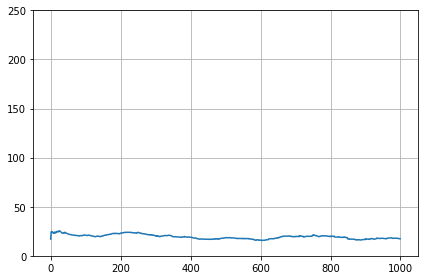

In [61]:
saveHyperparametersToFile()

smoothed_scores_dsqn_all = []
dsqn_completion_after = []
simulation_time = 10
scaler = init_scaler()

for i_run in range(n_runs):
    print("Run # {}".format(i_run) + ' at '+ getDateTime())
    seed = seeds[i_run]

    torch.manual_seed(seed)
    random.seed(seed)

    policy_net = DSNN(architecture, seed, alpha, beta, 1, threshold, simulation_time, scaler)
    target_net = DSNN(architecture, seed, alpha, beta, 1, threshold, simulation_time, scaler)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau, SQN=True, quantization=False)

    smoothed_scores, scores, best_average_after = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DSQN_{}'.format(i_run), smoothed_scores)
    plot_score(smoothed_scores,i_run)

    # save smoothed scores in list to plot later
    smoothed_scores_dsqn_all.append(smoothed_scores)
    dsqn_completion_after.append(best_average_after)
    print("")
print("Finished at "+ getDateTime())

## DSQN Plots

In [ ]:
result_dir = "/content/drive/My Drive/Uni/MasterArbeit/dsqn_examples/results/result_20_default_2021113"

In [ ]:
smoothed_scores_dsqn_all = loadScores(result_dir,"smoothed_scores_DSQN",5)

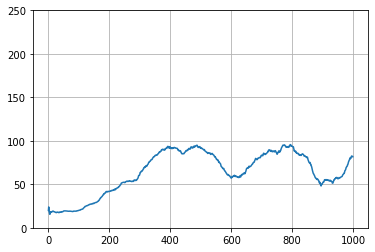

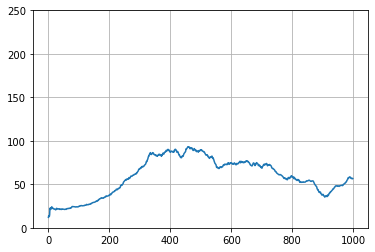

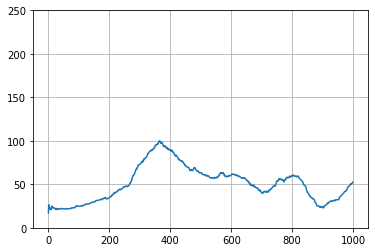

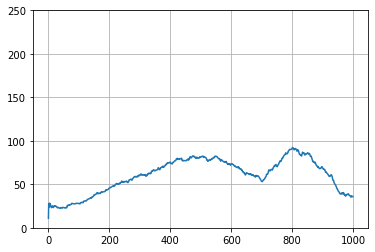

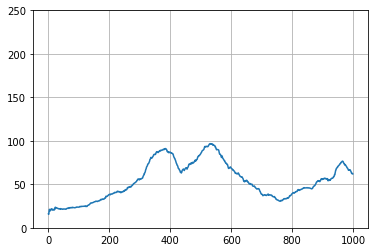

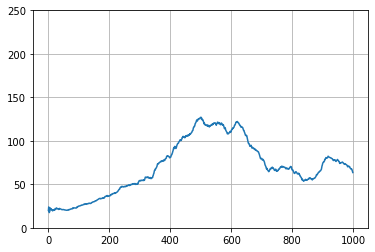

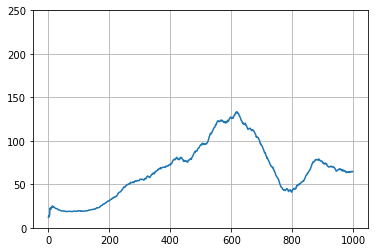

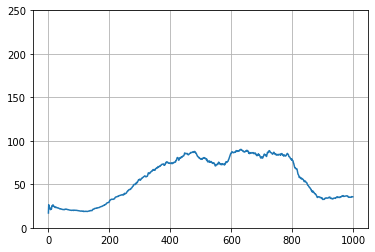

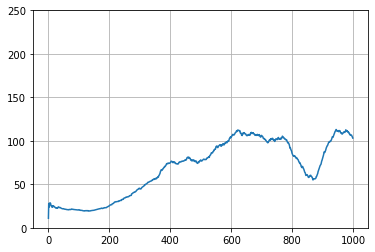

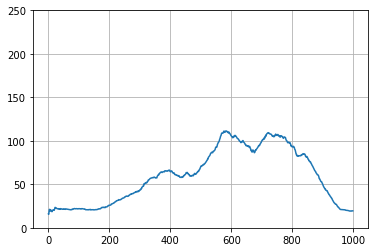

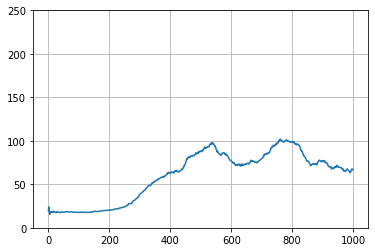

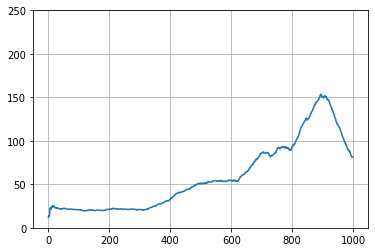

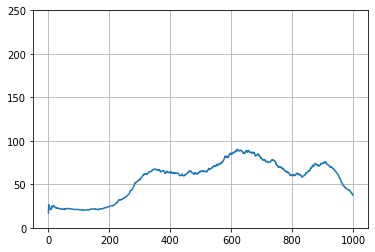

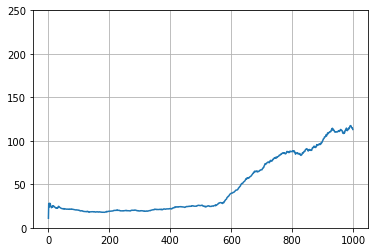

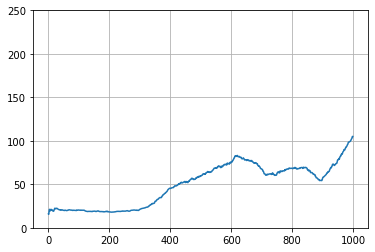

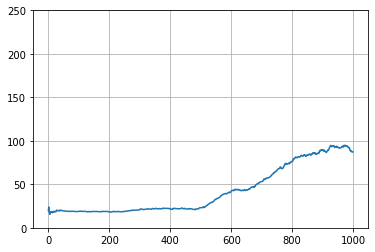

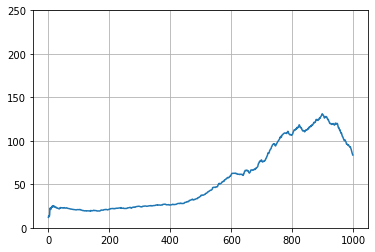

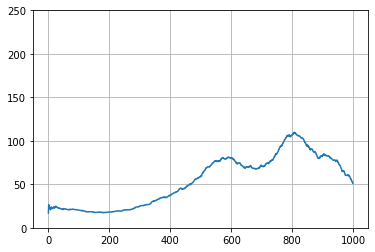

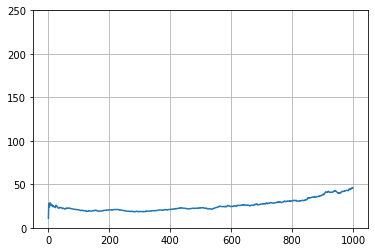

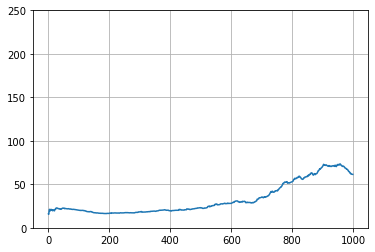

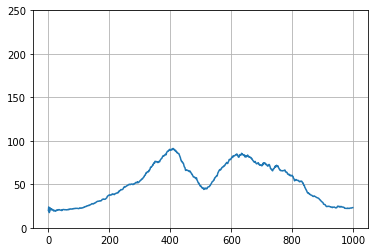

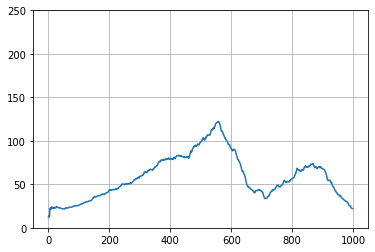

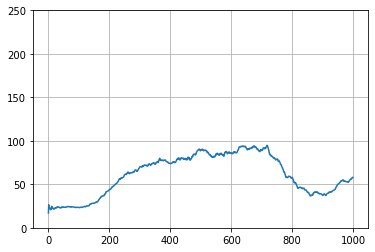

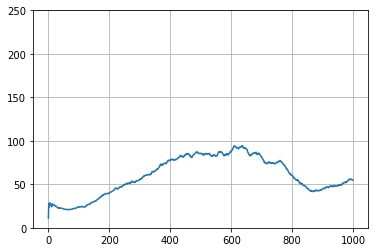

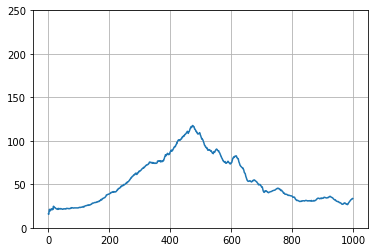

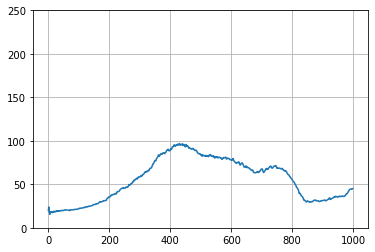

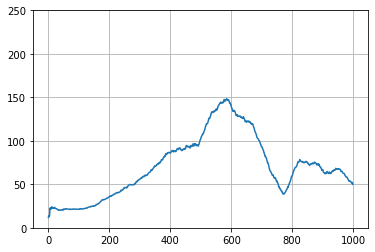

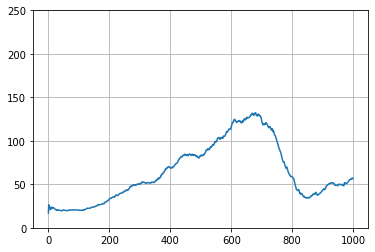

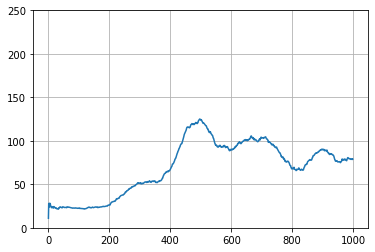

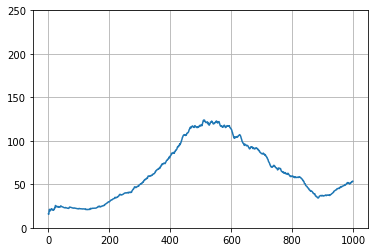

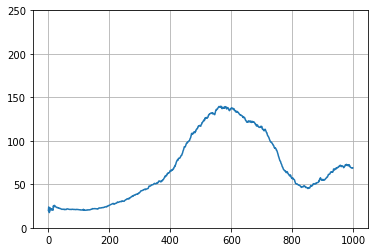

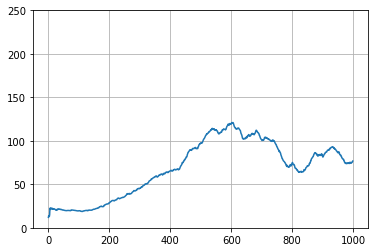

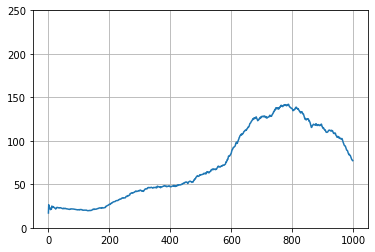

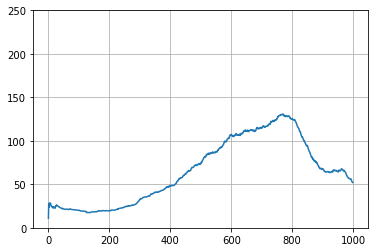

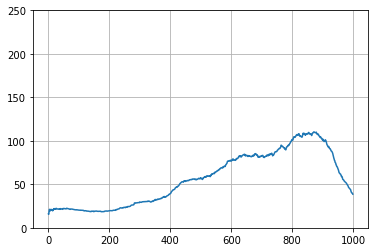

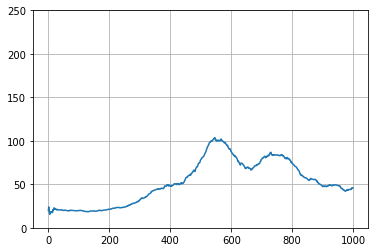

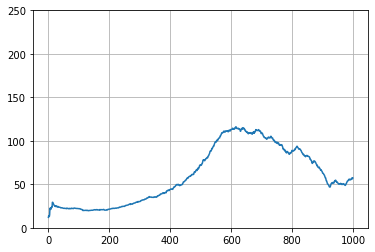

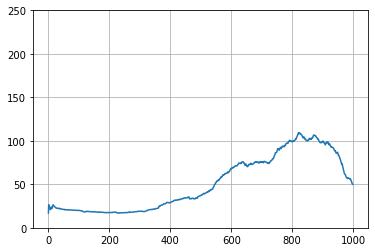

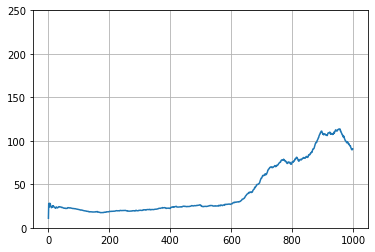

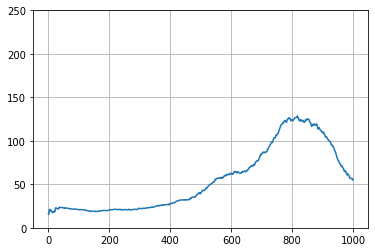

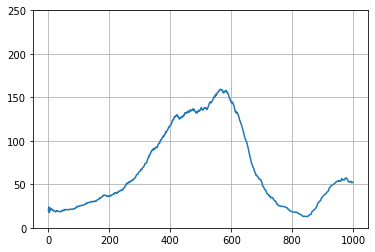

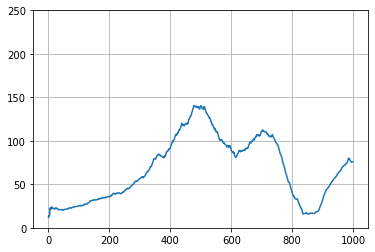

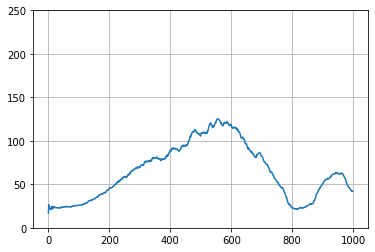

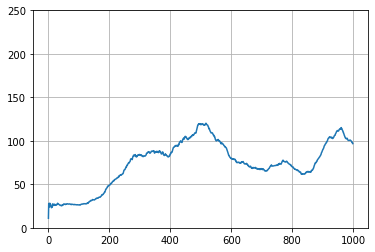

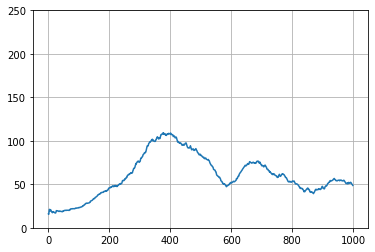

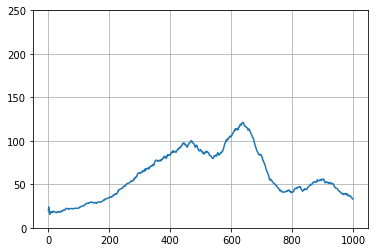

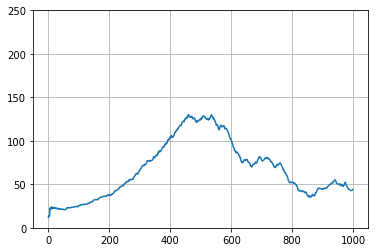

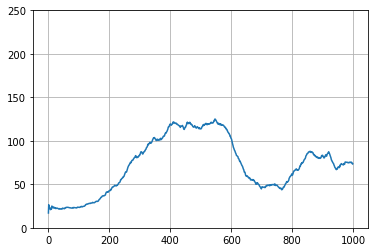

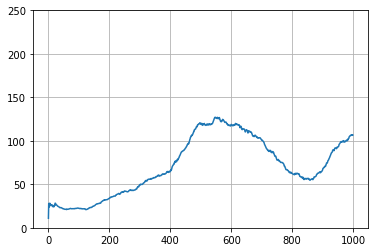

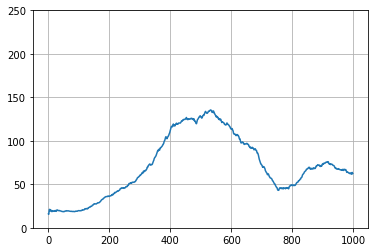

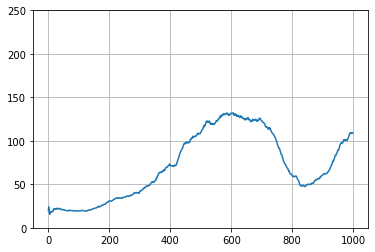

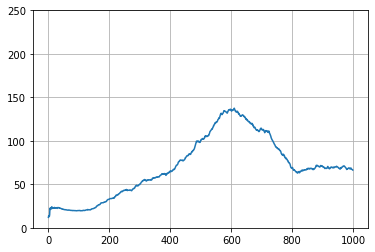

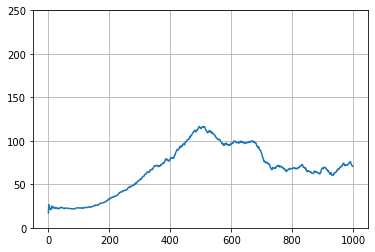

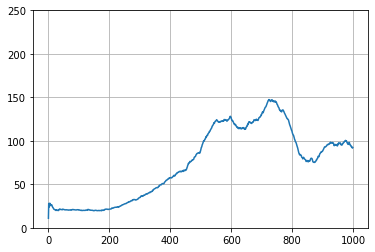

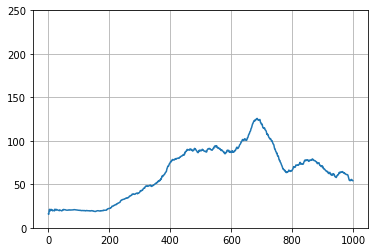

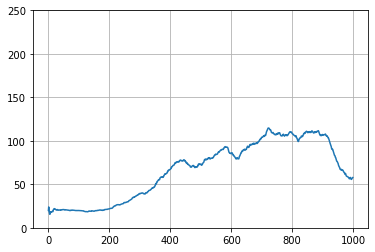

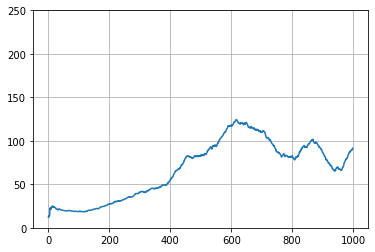

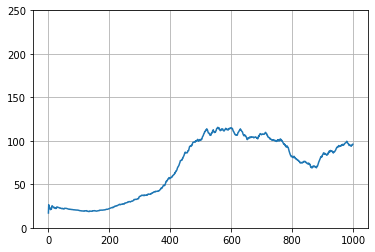

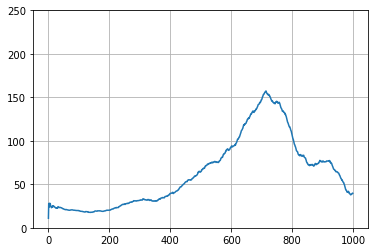

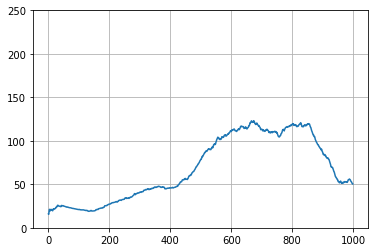

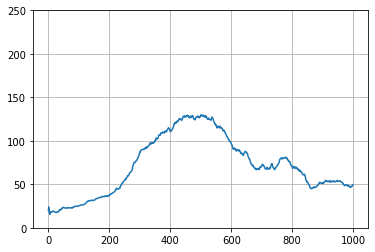

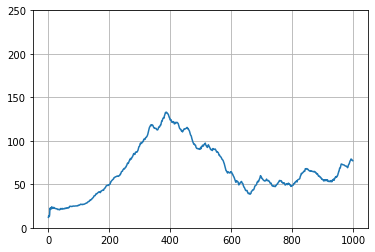

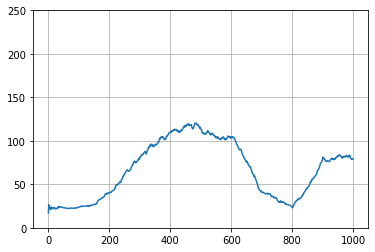

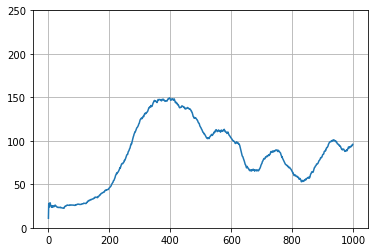

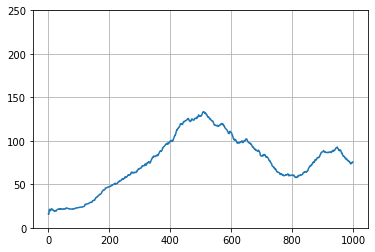

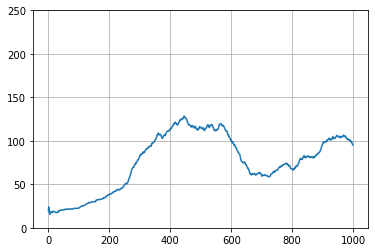

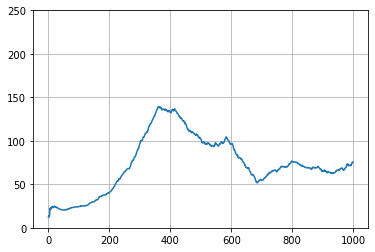

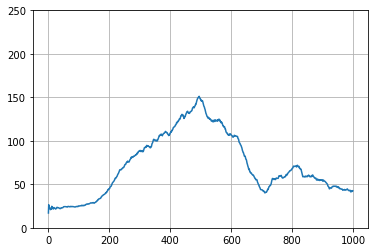

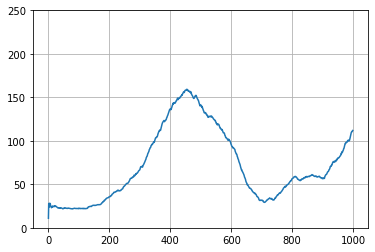

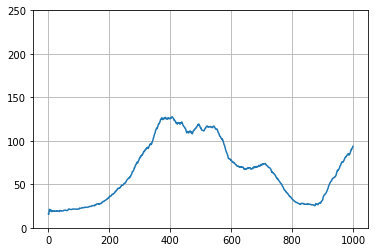

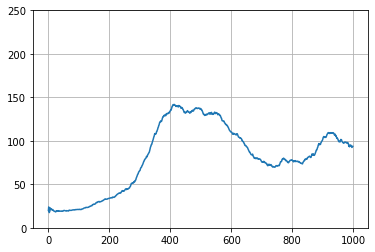

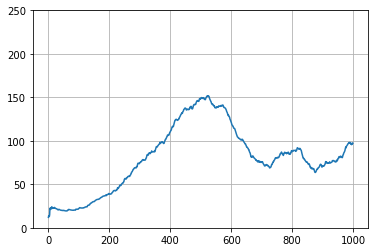

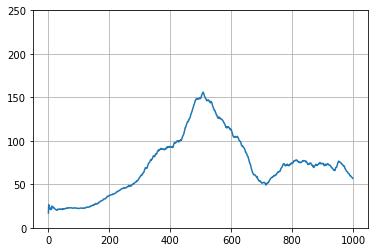

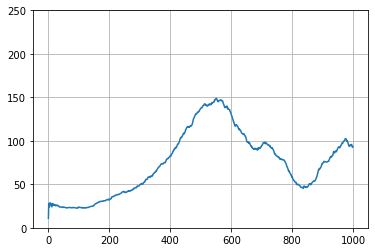

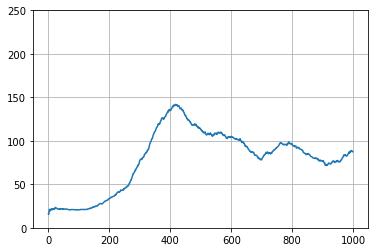

In [13]:
# Plot scores of individual runs
for i in range(len(smoothed_scores_dsqn_all)):
    fig = plt.figure()
    plt.plot(smoothed_scores_dsqn_all[i])
    plt.ylim(0, 250)
    plt.grid(True)
    #plt.savefig(result_dir + '/training_dsqn_{}.png'.format(i), dpi=1000)
    plt.show()

In [59]:
best_runs = [ i for i in range(29)]

In [21]:
len(smoothed_scores_dsqn_all)

75

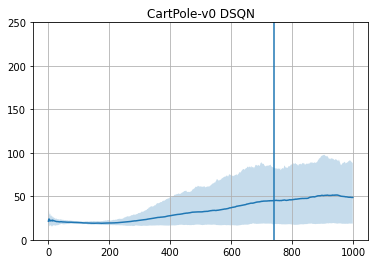

In [60]:
best_smoothed_scores_dsqn = [[]]*len(smoothed_scores_dsqn_all)
for i in range(len(smoothed_scores_dsqn_all)):
    best_smoothed_scores_dsqn[i] = smoothed_scores_dsqn_all[best_runs[i]]

mean_smoothed_scores_dsqn = np.mean(best_smoothed_scores_dsqn, axis=0)


fig = plt.figure()
plt.plot(range(len(best_smoothed_scores_dsqn[0])), mean_smoothed_scores_dsqn)
plt.fill_between(range(len(best_smoothed_scores_dsqn[0])),
                 np.nanpercentile(best_smoothed_scores_dsqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dsqn, 97, axis=0), alpha=0.25)

try: # in case the notebook expires, the dsqn_completions cannot be reloaed
    if(dsqn_completion_after):
      avg_dsqn_completion_after = [[]]*len(dsqn_completion_after)
      for i in range(len(dsqn_completion_after)):
          avg_dsqn_completion_after[i] = dsqn_completion_after[best_runs[i]]
      avg_dsqn_completion_after = np.mean(avg_dsqn_completion_after)
      plt.vlines(avg_dsqn_completion_after, 0, 250, 'C0')
except NameError:
    dsqn_completion_after = None


plt.ylim(0, 250)
plt.grid(True)
plt.savefig(result_dir + '/DSQN_training.png', dpi=1000)
plt.title('CartPole-v0 DSQN')
plt.show()

# Quantized DSQN

## Quantized DSQN Training

In [14]:
smoothed_scores_dsqn_quantized_all = []
dsqn_quantized_completion_after = []
simulation_time = 8

for i_run in range(n_runs):
    print("Run # {}".format(i_run))
    seed = seeds[i_run]

    torch.manual_seed(seed)
    random.seed(seed)

    policy_net = DSQN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold, simulation_time)
    target_net = DSQN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold, simulation_time)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau, SQN=True, two_neurons=False,
                  quantization=True)

    smoothed_scores, scores, best_average_after = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DSQN_Loihi_{}'.format(i_run), smoothed_scores)

    # save smoothed scores in list to plot later
    smoothed_scores_dsqn_quantized_all.append(smoothed_scores)
    dsqn_quantized_completion_after.append(best_average_after)
    print("")

Run # 0


NameError: name 'DSQN' is not defined

In [ ]:
smoothed_scores_dsqn_quantized_all = smoothed_scores_dsqn_all
dsqn_quantized_completion_after = dsqn_completion_after

In [ ]:
policy_net = DSQN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold, simulation_time, two_neurons=False)

In [ ]:
dsqn_completion_after

In [ ]:
policy_net.weights = weights

In [ ]:
seed = seeds[0]
policy_net = DSQN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold, simulation_time, two_neurons=False)
target_net = DSQN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold, simulation_time, two_neurons=False)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, 0, result_dir, seed, tau, SQN=True, two_neurons=False)

In [ ]:
weights = policy_net.weights

In [ ]:
weights

In [ ]:
q_weights = agent.quantize_weights(weights)

In [ ]:
q_weights

In [ ]:
quant_weights = [q_w.tensor.float() for q_w in q_weights]

In [ ]:
quant_weights[0].requires_grad = True

In [ ]:
quant_weights

In [ ]:
step = (1.8 + 1.8)/255

In [ ]:
w = np.concatenate((weights[0].detach().numpy()[0], weights[0].detach().numpy()[1], weights[0].detach().numpy()[2], weights[0].detach().numpy()[3]))
bins = np.arange(-1.8, 1.8, step)
plt.hist(w, bins)
plt.title('FP32 Weights')
plt.savefig('weights_fp32.png', dpi=1000)

In [ ]:
w = np.concatenate((quant_weights[0].detach().numpy()[0], quant_weights[0].detach().numpy()[1], quant_weights[0].detach().numpy()[2], quant_weights[0].detach().numpy()[3]), axis=0)
bins = range(-128, 127)
plt.hist(w, bins)
plt.title('Quantized Weights')
plt.savefig('weights_quantized.png', dpi=1000)

In [ ]:
policy_net.weights = quant_weights

In [ ]:
env = gym.make(env_name)

In [ ]:
obs = env.reset()

## Plot Quantized DSQN Training

In [ ]:
smoothed_scores_dsqn_quantized_0 = np.load('result_23_2021416/smoothed_scores_DSQN_0.npy')
smoothed_scores_dsqn_quantized_1 = np.load('result_23_2021416/smoothed_scores_DSQN_1.npy')
smoothed_scores_dsqn_quantized_2 = np.load('result_23_2021416/smoothed_scores_DSQN_2.npy')
smoothed_scores_dsqn_quantized_3 = np.load('result_23_2021416/smoothed_scores_DSQN_3.npy')
smoothed_scores_dsqn_quantized_4 = np.load('result_23_2021416/smoothed_scores_DSQN_4.npy')
smoothed_scores_dsqn_quantized_5 = np.load('result_23_2021416/smoothed_scores_DSQN_5.npy')
smoothed_scores_dsqn_quantized_6 = np.load('result_23_2021416/smoothed_scores_DSQN_6.npy')
smoothed_scores_dsqn_quantized_7 = np.load('result_23_2021416/smoothed_scores_DSQN_7.npy')
smoothed_scores_dsqn_quantized_8 = np.load('result_23_2021416/smoothed_scores_DSQN_8.npy')
smoothed_scores_dsqn_quantized_9 = np.load('result_23_2021416/smoothed_scores_DSQN_9.npy')
smoothed_scores_dsqn_quantized_all = [smoothed_scores_dsqn_quantized_0, smoothed_scores_dsqn_quantized_1, smoothed_scores_dsqn_quantized_2, smoothed_scores_dsqn_quantized_3, smoothed_scores_dsqn_quantized_4, smoothed_scores_dsqn_quantized_5, smoothed_scores_dsqn_quantized_6, smoothed_scores_dsqn_quantized_7, smoothed_scores_dsqn_quantized_8, smoothed_scores_dsqn_quantized_9]

In [ ]:
best_smoothed_scores_dsqn_quantized = [smoothed_scores_dsqn_quantized_all[best_runs[0]],
                             smoothed_scores_dsqn_quantized_all[best_runs[1]],
                             smoothed_scores_dsqn_quantized_all[best_runs[2]],
                             smoothed_scores_dsqn_quantized_all[best_runs[3]],
                             smoothed_scores_dsqn_quantized_all[best_runs[4]],
                             smoothed_scores_dsqn_quantized_all[best_runs[5]],
                             smoothed_scores_dsqn_quantized_all[best_runs[6]],
                             smoothed_scores_dsqn_quantized_all[best_runs[7]],
                             smoothed_scores_dsqn_quantized_all[best_runs[8]],
                             smoothed_scores_dsqn_quantized_all[best_runs[9]]]
mean_smoothed_scores_dsqn_quantized = np.mean(best_smoothed_scores_dsqn_quantized, axis=0)

avg_dsqn_quantized_completion_after = np.mean([dsqn_quantized_completion_after[best_runs[0]],
                                dsqn_quantized_completion_after[best_runs[1]],
                                dsqn_quantized_completion_after[best_runs[2]],
                                dsqn_quantized_completion_after[best_runs[3]],
                                dsqn_quantized_completion_after[best_runs[4]],
                                dsqn_quantized_completion_after[best_runs[5]],
                                dsqn_quantized_completion_after[best_runs[6]],
                                dsqn_quantized_completion_after[best_runs[7]],
                                dsqn_quantized_completion_after[best_runs[8]],
                                dsqn_quantized_completion_after[best_runs[9]]])

fig = plt.figure()
plt.plot(range(len(best_smoothed_scores_dsqn_quantized[0])), mean_smoothed_scores_dsqn_quantized)
plt.fill_between(range(len(best_smoothed_scores_dsqn_quantized[0])),
                 np.nanpercentile(best_smoothed_scores_dsqn_quantized, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dsqn_quantized, 97, axis=0), alpha=0.25)

plt.vlines(avg_dsqn_quantized_completion_after, 0, 250, 'C0')


plt.ylim(0, 250)
plt.grid(True)
plt.savefig(result_dir + '/DSQN_training.png', dpi=1000)
plt.title('CartPole-v0 DSQN Quantized')
plt.show()

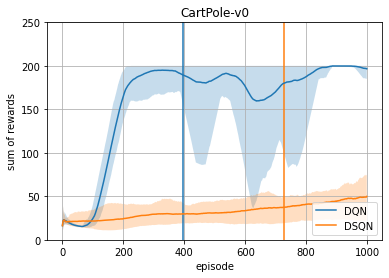

In [ ]:
# Plot smoothed DQN vs. DSQN Training
#mean_smoothed_scores_dqn = np.mean(smoothed_scores_dqn_all, axis=0)
#mean_smoothed_scores_dsqn = np.mean(smoothed_scores_dsqn_all, axis=0)

fig = plt.figure()

dqn = plt.plot(range(len(best_smoothed_scores_dqn[0])), mean_smoothed_scores_dqn, color='C0', label='DQN')
plt.fill_between(range(len(best_smoothed_scores_dqn[0])),
                 np.nanpercentile(best_smoothed_scores_dqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dqn, 97, axis=0), alpha=0.25)
plt.vlines(avg_dqn_completion_after, 0, 250, 'C0')

dsqn = plt.plot(range(len(best_smoothed_scores_dsqn[0])), mean_smoothed_scores_dsqn, color='C1', label='DSQN')
plt.fill_between(range(len(best_smoothed_scores_dsqn[0])),
                 np.nanpercentile(best_smoothed_scores_dsqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dsqn, 97, axis=0), alpha=0.25)
plt.vlines(avg_dsqn_completion_after, 0, 250, 'C1')

#dsqn_quantized = plt.plot(range(len(best_smoothed_scores_dsqn_quantized[0])), mean_smoothed_scores_dsqn_quantized, color='C2', label='Quantized DSQN')
#plt.fill_between(range(len(best_smoothed_scores_dsqn_quantized[0])),
#                 np.nanpercentile(best_smoothed_scores_dsqn_quantized, 2, axis=0),
#                 np.nanpercentile(best_smoothed_scores_dsqn_quantized, 97, axis=0), alpha=0.25)
#plt.vlines(avg_dsqn_quantized_completion_after, 0, 250, 'C2')


plt.grid(True)
plt.ylim(0, 250)
plt.legend(loc='lower right')
plt.xlabel('episode')
plt.ylabel('sum of rewards')
plt.title(env_name)
plt.savefig(result_dir + '/DQN_vs_DSQN_training.png', dpi=1000)
plt.show()

## Evaluate trained DQN and DSQN models

In [ ]:
gym_evaluation_seeds = [random.getrandbits(32) for _ in range(n_evaluations)]

In [ ]:
import importlib


In [ ]:
import agent

In [ ]:
importlib.reload(agent)

<module 'agent' from '/content/agent.py'>

In [ ]:
from agent import Agent, ReplayBuffer

In [ ]:
test_agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau, SQN=True, quantization=False)

In [ ]:
# Test best trained DQN on the same environment for 200 timesteps
evaluation_dqn_200 = []
for i in best_runs:
    print("Run # {}".format(i))
    dqn = QNetwork(architecture, 1).to(device)
    dqn.load_state_dict(torch.load(result_dir + '/checkpoint_DQN_{}.pt'.format(i)))
    rewards = test_agent.evaluate_agent(dqn, env, 100, 200, gym_evaluation_seeds, quantization=False)
    evaluation_dqn_200.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dqn_200', evaluation_dqn_200)
print("Total Mean Reward: {}".format(np.mean(evaluation_dqn_200)))
print("Total Deviation: {}".format(np.std(evaluation_dqn_200)))

Run # 0
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 1
Mean Rewards: 199.17
Deviation: 3.638832230262891
-----------------
Run # 2
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 3
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 4
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 5
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 6
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 7
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 8
Mean Rewards: 200.0
Deviation: 0.0
-----------------
Run # 9
Mean Rewards: 199.89
Deviation: 0.7196526940128829
-----------------
Total Mean Reward: 199.906
Total Deviation: 1.1988177509529963


In [ ]:
# Test best trained DQN on the same environment for 500 timesteps
evaluation_dqn_500 = []
for i in best_runs:
    print("Run # {}".format(i))
    dqn = QNetwork(architecture, 1).to(device)
    dqn.load_state_dict(torch.load(result_dir + '/checkpoint_DQN_{}.pt'.format(i)))
    rewards = test_agent.evaluate_agent(dqn, env, 100, 500, gym_evaluation_seeds, quantization=False)
    evaluation_dqn_500.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dqn_500', evaluation_dqn_500)
print("Total Mean Reward: {}".format(np.mean(evaluation_dqn_500)))
print("Total Deviation: {}".format(np.std(evaluation_dqn_500)))

Run # 0
Mean Rewards: 500.0
Deviation: 0.0
-----------------
Run # 1
Mean Rewards: 345.26
Deviation: 109.2267934162676
-----------------
Run # 2
Mean Rewards: 500.0
Deviation: 0.0
-----------------
Run # 3
Mean Rewards: 499.06
Deviation: 9.352881908802223
-----------------
Run # 4
Mean Rewards: 500.0
Deviation: 0.0
-----------------
Run # 5
Mean Rewards: 500.0
Deviation: 0.0
-----------------
Run # 6
Mean Rewards: 470.88
Deviation: 64.15579163255644
-----------------
Run # 7
Mean Rewards: 500.0
Deviation: 0.0
-----------------
Run # 8
Mean Rewards: 500.0
Deviation: 0.0
-----------------
Run # 9
Mean Rewards: 350.22
Deviation: 111.67054938523407
-----------------
Total Mean Reward: 466.542
Total Deviation: 80.39728997920264


In [ ]:
# Test best trained DQN on the same environment for 1000 timesteps
evaluation_dqn_1000 = []
for i in best_runs:
    print("Run # {}".format(i))
    dqn = QNetwork(architecture, 1).to(device)
    dqn.load_state_dict(torch.load(result_dir + '/checkpoint_DQN_{}.pt'.format(i)))
    rewards = test_agent.evaluate_agent(dqn, env, 100, 1000, gym_evaluation_seeds, quantization=False)
    evaluation_dqn_1000.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dqn_1000', evaluation_dqn_1000)
print("Total Mean Reward: {}".format(np.mean(evaluation_dqn_1000)))
print("Total Deviation: {}".format(np.std(evaluation_dqn_1000)))

Run # 0
Mean Rewards: 1000.0
Deviation: 0.0
-----------------
Run # 1
Mean Rewards: 387.49
Deviation: 196.79743367229156
-----------------
Run # 2
Mean Rewards: 1000.0
Deviation: 0.0
-----------------
Run # 3
Mean Rewards: 990.14
Deviation: 70.4824829301579
-----------------
Run # 4
Mean Rewards: 1000.0
Deviation: 0.0
-----------------
Run # 5
Mean Rewards: 991.11
Deviation: 40.25019130389321
-----------------
Run # 6
Mean Rewards: 782.0
Deviation: 249.85511801842284
-----------------
Run # 7
Mean Rewards: 1000.0
Deviation: 0.0
-----------------
Run # 8
Mean Rewards: 1000.0
Deviation: 0.0
-----------------
Run # 9
Mean Rewards: 462.63
Deviation: 295.4982455108659
-----------------
Total Mean Reward: 861.337
Total Deviation: 267.287275101154


In [ ]:
# Test best trained DSQN on the same environment for 200 timesteps
evaluation_dsqn_200 = []
for i in best_runs:
    print("Run # {}".format(i))
    dsqn = DSQN(architecture, 0, alpha, beta, weight_scale, 1, threshold, simulation_time)
    dsqn.load_state_dict(torch.load(result_dir + '/checkpoint_DSQN_{}.pt'.format(i)))
    rewards = agent.evaluate_agent(dsqn, env, 100, 200, gym_evaluation_seeds, quantization=False)
    evaluation_dsqn_200.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dsqn_200', evaluation_dsqn_200)
print("Total Mean Reward: {}".format(np.mean(evaluation_dsqn_200)))
print("Total Deviation: {}".format(np.std(evaluation_dsqn_200)))

Run # 0


NameError: ignored

In [ ]:
# Test best trained DSQN on the same environment for 200 timesteps
evaluation_dsqn_500 = []
for i in best_runs:
    print("Run # {}".format(i))
    dsqn = DSQN(architecture, 0, alpha, beta, weight_scale, 1, threshold, simulation_time)
    dsqn.load_state_dict(torch.load(result_dir + '/checkpoint_DSQN_{}.pt'.format(i)))
    rewards = agent.evaluate_agent(dsqn, 100, 500, gym_evaluation_seeds)
    evaluation_dsqn_500.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dsqn_500', evaluation_dsqn_500)
print("Total Mean Reward: {}".format(np.mean(evaluation_dsqn_500)))
print("Total Deviation: {}".format(np.std(evaluation_dsqn_500)))

In [ ]:
# Test best trained DSQN on the same environment for 200 timesteps
evaluation_dsqn_1000 = []
for i in best_runs:
    print("Run # {}".format(i))
    dsqn = DSQN(architecture, 0, alpha, beta, weight_scale, 1, threshold, simulation_time)
    dsqn.load_state_dict(torch.load(result_dir + '/checkpoint_DSQN_{}.pt'.format(i)))
    rewards = agent.evaluate_agent(dsqn, 100, 1000, gym_evaluation_seeds)
    evaluation_dsqn_1000.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dsqn_1000', evaluation_dsqn_1000)
print("Total Mean Reward: {}".format(np.mean(evaluation_dsqn_1000)))
print("Total Deviation: {}".format(np.std(evaluation_dsqn_1000)))

In [ ]:
means = [np.mean(evaluation_dqn_200), np.mean(evaluation_dsqn_200)]
stds = [np.std(evaluation_dqn_200), np.std(evaluation_dsqn_200)]
#x_pos = np.arange(len(means))
x_pos = [0.5, .65]

plt.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, capsize=10, width=0.1)
plt.ylim(0, 250)
plt.xticks(x_pos, ['DQN', 'DSQN'])
plt.ylabel('Accumlative Reward')
plt.title('CartPole-v0 Evaluation over 200 timesteps')
plt.grid(True)
plt.savefig(result_dir + '/CartPole_evaluation_200.png', dpi=1000)

In [ ]:
means = [np.mean(evaluation_dqn_500), np.mean(evaluation_dsqn_500)]
stds = [np.std(evaluation_dqn_500), np.std(evaluation_dsqn_500)]
x_pos = [0.5, .65]

plt.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, capsize=10, width=0.1)
plt.ylim(0, 550)
plt.xticks(x_pos, ['DQN', 'DSQN'])
plt.ylabel('Accumlative Reward')
plt.title('CartPole-v0 Evaluation over 500 timesteps')
plt.grid(True)
plt.savefig(result_dir + '/CartPole_evaluation_500.png', dpi=1000)

In [ ]:
means = [np.mean(evaluation_dqn_1000), np.mean(evaluation_dsqn_1000)]
stds = [np.std(evaluation_dqn_1000), np.std(evaluation_dsqn_1000)]
x_pos = [0.5, .65]

plt.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, capsize=10, width=0.1)
plt.ylim(0, 1150)
plt.xticks(x_pos, ['DQN', 'DSQN'])
plt.ylabel('Accumlative Reward')
plt.title('CartPole-v0 Evaluation over 1000 timesteps')
plt.grid(True)
plt.savefig(result_dir + '/CartPole_evaluation_1000.png', dpi=1000)

In [ ]:
# Get the membrane potential of the first layer, first item in batch
potential = [mem[1][0] for mem in mem_rec]
neuron1 = [p[0] for p in potential]
neuron2 = [p[1] for p in potential]

In [ ]:
# Plot the membrane potential for both output neurons for one random run before training
plt.plot(neuron1, color='b', label='Output Neuron 1')
plt.plot(neuron2, color='g', label='Output Neuron 2')
plt.grid(True)
plt.ylim(-25, 25)
plt.xlabel('time steps')
plt.ylabel('membrane potential')
plt.legend(loc='upper right')
plt.savefig('cartpole_output_neurons_potential_b4_training.png', dpi=1000)

In [ ]:
# Get the membrane potential of the hidden layer neurons
potential = [mem[0][0] for mem in mem_rec]
neurons = []
for i in range(len(potential[0])):
    neurons.append([p[i] for p in potential])

In [ ]:
# Plot the membrane potential for the hidden layer neurons
for i in range(len(neurons)):
    plt.plot(neurons[i], label='neuron {}'.format(i + 1))
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('membrane potential')

Test Code

In [ ]:
# Fill the play buffer with some data
env = gym.make(env_name)
memory = ReplayBuffer(replay_memory_size, batch_size, random_seeds[0])
for i in range(1000):
    print("Episode: {}".format(i), end='\r')
    state = env.reset()
    for t in range(1000):
    for t in range(1000):
        action = random.randint(0, 1)
        next_state, reward, done, _ = env.step(action)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        if done:
            break


In [ ]:
import sunblaze_envs

In [ ]:
random_env = sunblaze_envs.make('SunblazeCartPoleRandomNormal-v0')

In [ ]:
result_dir = 'result_20_2021122'


In [ ]:
evaluation_dsqn_random_200 = []

dsqn = DSQN(architecture, 0, alpha, beta, weight_scale, 1, threshold, simulation_time)
optimizer = optim.Adam(dsqn.parameters(), lr=learning_rate)

for i in best_runs:
    print("Run # {}".format(i))
    dsqn = DSQN(architecture, 0, alpha, beta, weight_scale, 1, threshold, simulation_time)
    dsqn.load_state_dict(torch.load(result_dir + '/checkpoint_DSQN_{}.pt'.format(i)))
    
    agent = Agent(env_name, dsqn, dsqn, architecture, batch_size,
              replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
              update_every, target_update_frequency, optimizer, learning_rate,
              num_episodes, max_steps, 0, result_dir, 0, tau, SQN=True, two_neurons=False, random=True)
    
    rewards = agent.evaluate_agent(dsqn, 100, 200, gym_evaluation_seeds)
    evaluation_dsqn_random_200.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dsqn_200', evaluation_dsqn_random_200)
print("Total Mean Reward: {}".format(np.mean(evaluation_dsqn_random_200)))
print("Total Deviation: {}".format(np.std(evaluation_dsqn_random_200)))

In [ ]:
evaluation_dqn_random_200 = []

for i in best_runs:
    print("Run # {}".format(i))
    dqn = QNetwork(architecture, 1).to(device)
    dqn.load_state_dict(torch.load(result_dir + '/checkpoint_DQN_{}.pt'.format(i)))
    rewards = agent.evaluate_agent(dqn, 100, 200, gym_evaluation_seeds)
    evaluation_dqn_random_200.extend(rewards)
    print("Mean Rewards: {}".format(np.mean(rewards)))
    print("Deviation: {}".format(np.std(rewards)))
    print("-----------------")
np.save(result_dir + '/evaluation_dqn_200', evaluation_dqn_random_200)
print("Total Mean Reward: {}".format(np.mean(evaluation_dqn_random_200)))
print("Total Deviation: {}".format(np.std(evaluation_dqn_random_200)))

In [ ]:
result_dir